# More Advanced Techniques (and Architectures)
We have thus far studied a number of convolutional networks for performing digits classification, specifically using the MNIST dataset. However, more complicated classification problems will require more complicated architectures and more involved methods for regularizing the data. For instance, object recognition requires more knowledge than simple handwriting digits. The complexities of the picture are more varied, color has an influence, and much more. Therefore, the simple convolutions that we used before might not be expressive enough without a number of additional layers. 

Even so, there are still some techniques we can use to help in the MNIST data. Some of these concepts we have already talked about, such as different initializations and different regularizers. Namely, we will cover these concepts:

- Expansion
- Initialization
- Batch Normalization
- Ensembling

After going through this tutorial, you will have an understanding of how to use some of the more advanced techniques--however we are limited here by the hardware and time in lecture. Many modern architectures can take days to train and are extremely deep (look at the 100+ layers of ResNet-112). However, some of the architectures from ~2013 and ~2014 are manageable to investigate and take only a few hours to train. We will cover a few concepts for getting models up and running, and maybe even use more some complicated architectures. Let's get started! 

This is also an excellent tutorial with even more information than I am showing for the fine tuning techniques:
- https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__

Using TensorFlow backend.


'2.0.2'

In [5]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    
        

In [4]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images.astype(np.float32), labels.reshape((-1,1)).astype(np.int32)

X_train, y_train = load_mnist('data/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0
X_test = X_test/255.0

NUM_CLASSES = 10
img_wh = 28

# NEW: Let's start by fixing the sizes
X_train = np.expand_dims(X_train.reshape((-1,img_wh,img_wh)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3)
# the image data has been resized to (samples,image_rows,image_cols,image_channels)

# and one hot encoding the output values
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

Rows: 60000, columns: 784
Rows: 10000, columns: 784


(60000, 28, 28, 1)


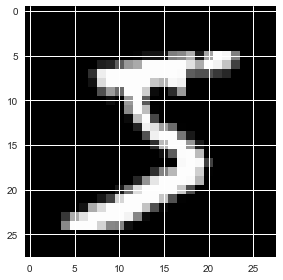

In [12]:

print(X_train.shape)
imshow(X_train[0].squeeze())

## Starting simple
Let's first start by using data expansion on the MNIST dataset.

In [13]:
%%time 

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

datagen.fit(X_train)

cnn = Sequential()

cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                   epochs=5, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )


Epoch 1/5
468/468 [==============================] - 308s - loss: 0.4373 - acc: 0.8621 - val_loss: 0.0685 - val_acc: 0.9776

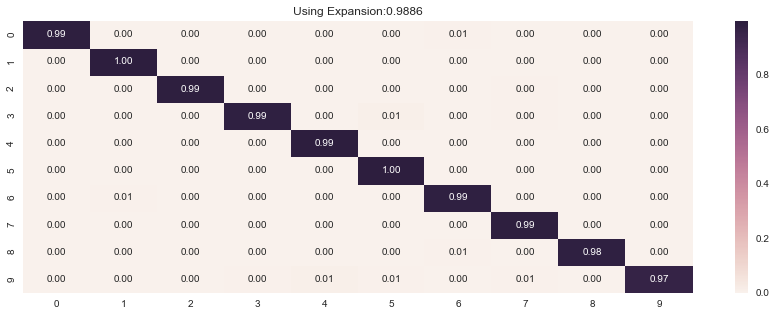

In [27]:
summarize_net(cnn, X_test, y_test, title_text='Using Expansion:')

In [28]:
# what if we just want to use the validation data??
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
l2_lambda = 0.0001

# Use Kaiming He to regularize ReLU layers: https://arxiv.org/pdf/1502.01852.pdf
# Use Glorot/Bengio for linear/sigmoid/softmax: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf 
cnn = Sequential()

cnn.add(Conv2D(filters=32,
               input_shape = (img_wh,img_wh,1),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
       ))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, 
              activation='softmax', 
              kernel_initializer='glorot_uniform',
              kernel_regularizer=l2(l2_lambda)
             ))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                  steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                  epochs=50, verbose=1,
                  validation_data=(X_test,y_test_ohe),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
                 )

Epoch 1/50
468/468 [==============================] - 79s - loss: 0.5538 - acc: 0.8350 - val_loss: 0.1175 - val_acc: 0.9759

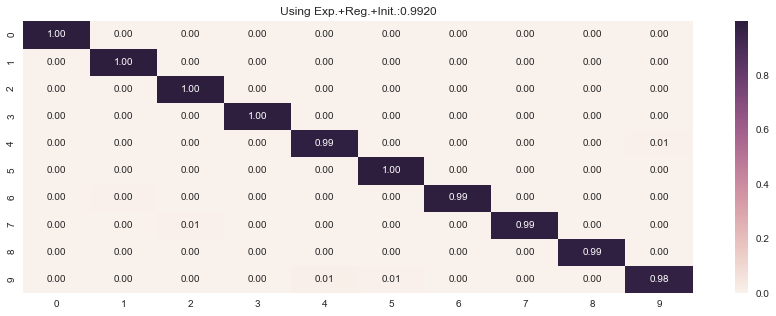

In [29]:
summarize_net(cnn, X_test, y_test, title_text='Using Exp.+Reg.+Init.:')

# Ensemble Nets
Now lets do the exact same thing, but with an average of three separate networks. 

To get this running, we are going to use the keras `Model API` which is different than the `Sequential API`. It requires that we explicitly define the inputs and outputs, and gives us a bit more control over the network topology.

- https://keras.io/models/model/

What's different?
- You will need to specify the input and output nodes explicitly.
 - `input_layer = Input(shape=(**insert shape here**))`
- You no longer `add` to a `Sequential`, you feed layer by layer:
 - `model.add(Dense())` becomes `layer2 = Dense()(input_layer)`
 - subsequent layers use temporary variables like `layer1` and `input_layer` above
- Tell the Model what the input and output temporary variables are:
 - `model = Model(inputs=input_layer,outputs=layer1)`
 - then you can call `model.compile()`
- A great example that uses the Model API with MNIST:
 - https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [47]:
%%time

from keras.layers import average 
from keras.models import Input, Model

num_ensembles = 3

input_holder = Input(shape=(img_wh, img_wh, 1))

branches = []
for _ in range(num_ensembles):

    conv1 = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,1),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu')(input_holder)
    
    max1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)

    conv2 = Conv2D(filters=32,
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu')(max1)
    
    max2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)


    # add one layer on flattened output
    drop1 = Dropout(0.25)(max2) # add some dropout for regularization after conv layers
    flat1 = Flatten()(drop1)
    dense1 = Dense(128, 
                  activation='relu',
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(l2_lambda)
                )(flat1)
    drop2 = Dropout(0.5)(dense1) # add some dropout for regularization, again!
    dense2 = Dense(NUM_CLASSES, 
                  activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  kernel_regularizer=l2(l2_lambda)
                 )(drop2)
    
    # now add this branch onto the master list
    branches.append(dense2)

# that's it, we just need to average the results
ave = average(branches)

# here is the secret sauce for setting the network using the 
#   Model API:
cnn_ens = Model(inputs=input_holder,outputs=ave)

# Let's train the model 
cnn_ens.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
cnn_ens.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
468/468 [==============================] - 209s - loss: 0.6977 - acc: 0.8040 - val_loss: 0.1385 - val_acc: 0.9759

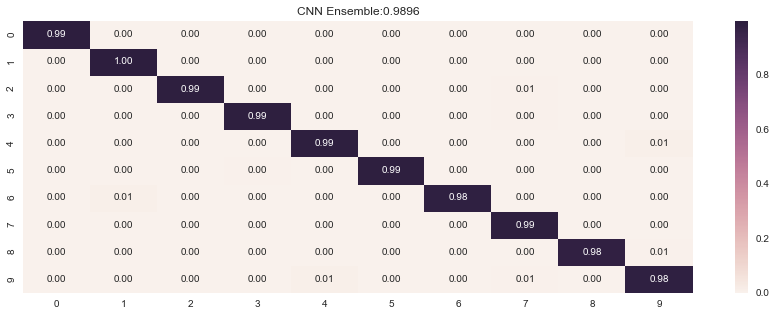

In [48]:
summarize_net(cnn_ens, X_test, y_test, title_text='CNN Ensemble:')

# Making LeNet-5
Okay, so LeNet was originally constructed in 2010---ancient in terms of deep learning years (that's a joke 🤷, ¯\\_(ツ)_/¯). 

The LeNet-5 architecture is described in the following:
![lenet5](https://blog.dataiku.com/hs-fs/hubfs/Dataiku%20Dec%202016/Image/le_net.png?t=1492456793499&width=1240&name=le_net.png)

In [49]:
%%time

# now lets use the LeNet architecture with batch norm
from keras.layers.normalization import BatchNormalization

lenet = Sequential()

lenet.add(Conv2D(filters=6,kernel_size=(5,5),
               input_shape = (img_wh,img_wh,1), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
model.add(BatchNormalization())
lenet.add(Activation("sigmoid"))

lenet.add(Conv2D(filters=16,kernel_size=(5,5), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))
lenet.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
model.add(BatchNormalization())
lenet.add(Activation("sigmoid"))
#lenet.add(Dropout(0.5))

lenet.add(Conv2D(filters=120,kernel_size=(1,1), 
               padding='valid', 
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda)))

lenet.add(Flatten())
lenet.add(Dense(84))
lenet.add(Activation("sigmoid"))
lenet.add(Dense(NUM_CLASSES))
lenet.add(Activation('softmax'))

lenet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='rmsprop', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transofmrations
lenet.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                      steps_per_epoch=int(len(X_train)/128), # how many generators to go through per epoch
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
468/468 [==============================] - 41s - loss: 1.4436 - acc: 0.5153 - val_loss: 0.4044 - val_acc: 0.9164

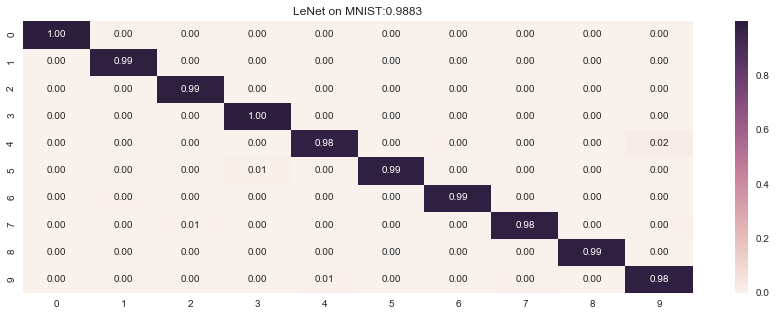

In [50]:
summarize_net(lenet, X_test, y_test, title_text='LeNet on MNIST:')

# Using Pre-trained Models

In [3]:
# manipulated from Keras Documentation
#  https://keras.io/applications/
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

res_model = ResNet50(weights='imagenet')

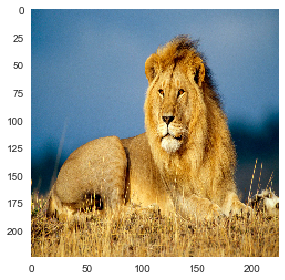

In [6]:
img_path = 'data/Simba.jpg'
img = image.load_img(img_path, target_size=(224, 224))
imshow(image.img_to_array(img)/255)
plt.grid()

In [7]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02129165', 'lion', 0.99565792), ('n02130308', 'cheetah', 0.00087043433), ('n07802026', 'hay', 0.00061646383)]


Predicted: [('n04285008', 'sports_car', 0.8644473), ('n03100240', 'convertible', 0.058732931), ('n02974003', 'car_wheel', 0.03669025)]


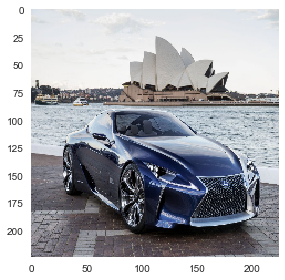

In [8]:
img_path = 'data/MyCar.jpg'
img = image.load_img(img_path, target_size=(224, 224))
imshow(image.img_to_array(img)/255)
plt.grid()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = res_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

# Transfer Learning With ResNet

In [10]:
from keras.datasets import cifar10
from scipy.misc import imresize

NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [12]:
%%time
x_train_up = [imresize(x,size=(224,224,3), interp='nearest') for x in x_train]
x_train_up = np.stack(x_train_up,axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x,size=(224,224,3), interp='nearest') for x in x_test]
x_test_up = np.stack(x_test_up,axis=0)
print(x_test_up.shape)

(50000, 224, 224, 3)
(10000, 224, 224, 3)
CPU times: user 25.6 s, sys: 29 s, total: 54.6 s
Wall time: 1min 48s


In [ ]:
# connect new layers to the output
x = res_model.output

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=res_model.input, outputs=predictions)

# freeze ResNet during training
for layer in res_model.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.fit(x_train_up,y_train_ohe,epochs=1,batch_size=128,verbose=1)

Epoch 1/1
27264/50000 [===============>..............] - ETA: 26394s - loss: 1.7373

In [ ]:
summarize_net(model, x_test_up, y_test, title_text='Transfer Learning, ResNet:')